In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding="valid")
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="valid")
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding="valid")
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        exit_outputs = []
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        exit_outputs.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        exit_outputs.append(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        exit_outputs.append(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x, exit_outputs

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
dataset = CIFAR10(root='./data', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='./data', train=False, transform=ToTensor())

Files already downloaded and verified


In [7]:
batch_size=128
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4)

In [8]:
model = Baseline().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)
epochs = 50

In [10]:
best_val_epoch, best_val_loss = 0, 1e6
break_flag = 0
for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    t_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    t_loss = t_loss / (i+1)
    t_loss = round(t_loss, 5)
    t_acc = round(100*(correct / total), 5)
    model.eval()
    v_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(val_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        v_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    v_loss = v_loss/(i+1)
    v_loss = round(v_loss, 5)
    v_acc = round(100*(correct / total), 5)
    if v_loss <= best_val_loss:
        torch.save(model.state_dict(), "cifar10_baseline_s_new.h5")
        best_val_epoch = epoch + 1
        best_val_loss = v_loss
        break_flag = 0
    else:
        break_flag += 1
    print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
    if break_flag >9 :
        break
print('Finished Training')
print('Best model saved at epoch: ', best_val_epoch)

Epoch[1]: t_loss: 2.29889 t_acc: 11.14889 v_loss: 2.29215 v_acc: 12.32
Epoch[2]: t_loss: 2.23459 t_acc: 17.26667 v_loss: 2.07062 v_acc: 22.92
Epoch[3]: t_loss: 1.9787 t_acc: 26.73111 v_loss: 1.92161 v_acc: 29.08
Epoch[4]: t_loss: 1.82587 t_acc: 32.88667 v_loss: 1.76816 v_acc: 36.12
Epoch[5]: t_loss: 1.68316 t_acc: 38.79333 v_loss: 1.65133 v_acc: 38.32
Epoch[6]: t_loss: 1.60626 t_acc: 41.44889 v_loss: 1.5806 v_acc: 41.96
Epoch[7]: t_loss: 1.52261 t_acc: 44.55111 v_loss: 1.48687 v_acc: 46.12
Epoch[8]: t_loss: 1.44283 t_acc: 47.46222 v_loss: 1.53098 v_acc: 45.72
Epoch[9]: t_loss: 1.38153 t_acc: 49.82667 v_loss: 1.37064 v_acc: 48.86
Epoch[10]: t_loss: 1.31688 t_acc: 52.53333 v_loss: 1.31549 v_acc: 51.98
Epoch[11]: t_loss: 1.26406 t_acc: 54.59556 v_loss: 1.25041 v_acc: 54.9
Epoch[12]: t_loss: 1.20859 t_acc: 56.71778 v_loss: 1.22329 v_acc: 56.1
Epoch[13]: t_loss: 1.1615 t_acc: 58.87333 v_loss: 1.16709 v_acc: 59.04
Epoch[14]: t_loss: 1.12103 t_acc: 60.20667 v_loss: 1.16366 v_acc: 58.9
Epoch[1

In [11]:
model.load_state_dict(torch.load("cifar10_baseline_s_new.h5", map_location='cpu'))
correct = 0
total = 0
pred, actual = [], []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = pred + list(predicted.detach().cpu().numpy())
        actual = actual + list(labels.detach().cpu().numpy())
print(f'Test accuracy: {100 * correct /total}')       

Test accuracy: 70.67


Classification Report
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1000
           1       0.83      0.81      0.82      1000
           2       0.62      0.61      0.61      1000
           3       0.57      0.50      0.53      1000
           4       0.66      0.66      0.66      1000
           5       0.63      0.63      0.63      1000
           6       0.80      0.75      0.78      1000
           7       0.66      0.78      0.72      1000
           8       0.82      0.80      0.81      1000
           9       0.73      0.82      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



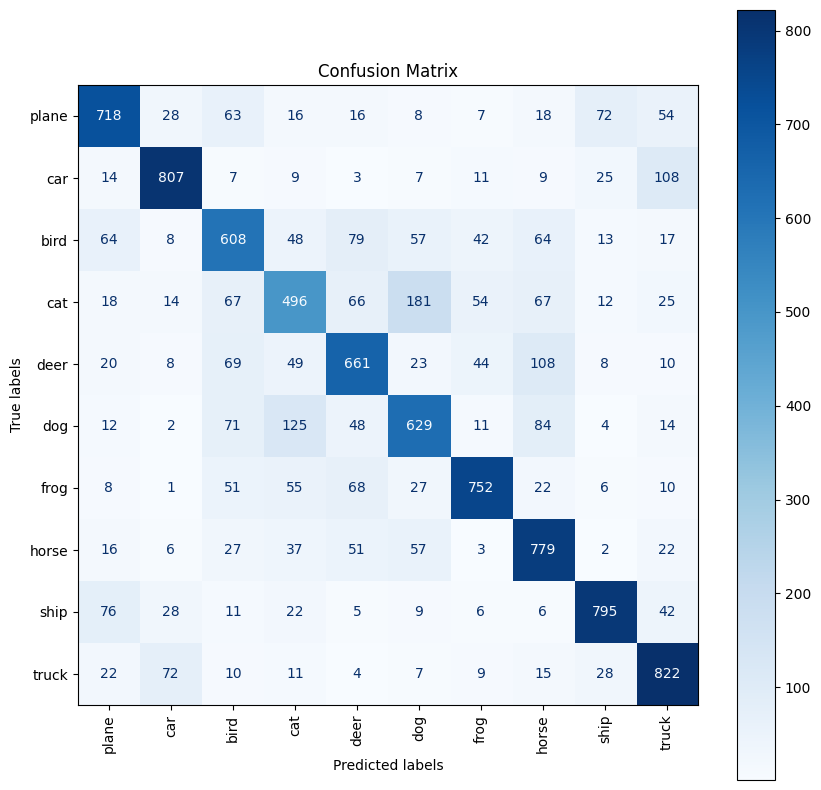

In [12]:
labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Classification Report')
print(classification_report(actual, pred))
cm = confusion_matrix(actual, pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax, cmap=plt.cm.Blues, values_format='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels)
plt.show()